In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

from scipy.stats import randint
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import normalize, PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

## Abstract
The UCB models predict electric power consumption of UCB buildings and the whole campus in 15-minute intervals. 
While accuracy varies accross the building being modelled, R2 values are in the 0.80-0.95 range suggesting strong predictive power. These models could be used to plan how many UCB buildings are kept in operation during PG&E power outages. This technique could also be applied to other buildings with high time-resolution power consumption data available.

## Introduction

PG&E power outages across California in 2019 caused numerous institutions to stop operating. UC Berkeley (UCB) lost PG&E coverage for 6 days in Oct 2019. With only its limited-capacity cogeneration plant (24.5MW) for backup power, UCB cancelled classes, closed the campus, and lost some electricity-dependent research materials. With future power outages expected, energy resiliency has become an important issue. Machine learning models which forecast building power consumption may help UCB and other institutions operate solely on backup power sources during future power outages.

Our models aims to predict electric power consumption of individual UCB buildings and the entire campus. These models can therefore forecast building power consumption at 15 minute intervals; they can also predict what power consumption would have been if buildings operated normally during power outages instead of being partially or fully shutdown. The models can predict whether or when electricity consumption will exceed the cogeneration plant’s capacity during power outage days.

## Data Description

**Dataset 1**

The UCB building power consumption data comes from the UCB Energy Office. A live dashboard of this data is available on the [UC Berkeley Energy Dashboard](https://engagementdashboard.com/ucb/ucb). The data features power consumption of individual campus buildings recorded at 15-minute intervals. To protect this data, the power consumption data from one unnamed building has been chosen and the power consumption data is expressed as a percentage of maximum consumption rather than in kW.

**Dataset 2**

The Berkeley weather data came from the [Berkeley Lab](https://sites.google.com/a/lbl.gov/lbnl-meteorological-data/lbnl-weather-data). It features weather data at the Lawrence Berekeley National Lb recorded at 15-minute intervals. This data is available through [Meso West](https://mesowest.utah.edu/cgi-bin/droman/meso_base_dyn.cgi?stn=LBNL1).

In [2]:
weather_raw = pd.read_csv(os.getcwd()+'\\data\\ucb_15min\\weather_15min\\LBNL_2019.csv')
weather_raw.head()

,Station_ID,Date_Time,pressure_set_1,air_temp_set_1,air_temp_set_2,relative_humidity_set_1,wind_speed_set_1,wind_direction_set_1,wind_gust_set_1,precip_accum_fifteen_minute_set_1,solar_radiation_set_1,volt_set_1,dew_point_temperature_set_1d,wind_chill_set_1d,wind_cardinal_direction_set_1d,sea_level_pressure_set_1d,heat_index_set_1d,wet_bulb_temperature_set_1d,altimeter_set_1d
0,NaN,NaN,Pascals,Celsius,Celsius,%,m/s,Degrees,m/s,Millimeters,W/m**2,volts,Celsius,Celsius,Code,Pascals,Celsius,Celsius,Pascals
1,LBNL1,11/30/2018 23:00 PST,98717.0,8.97,9.12,80.6,2.66,305.0,4.71,0.0,0.0,13.26,5.78,NaN,NW,101995.44,NaN,NaN,101947.17
2,LBNL1,11/30/2018 23:15 PST,98717.0,9.11,9.28,80.1,2.52,309.2,3.96,0.0,0.0,13.26,5.82,NaN,NW,101993.8,NaN,NaN,101947.17
3,LBNL1,11/30/2018 23:30 PST,98731.0,9.07,9.26,78.9,1.24,301.8,2.63,0.0,0.0,13.26,5.56,NaN,WNW,102008.74,NaN,NaN,101961.63
4,LBNL1,11/30/2018 23:45 PST,98717.0,9.17,9.33,77.98,0.75,286.7,1.91,0.0,0.0,13.26,5.49,NaN,WNW,101993.09,NaN,NaN,101947.17


In [3]:
scrambled_1 = pd.read_csv(os.getcwd()+'\\data\\ucb_15min\\2019\\scrambled_2.csv')
scrambled_1.head()

,Unnamed: 0,Date,kW
0,0,2018-12-01 00:00:00,27.506884
1,1,2018-12-01 00:15:00,26.788531
2,2,2018-12-01 00:30:00,27.988530
3,3,2018-12-01 00:45:00,27.243129
4,4,2018-12-01 01:00:00,28.424142


## Data Cleaning

Since the weather data had to be downloaded one year at a time, four weather datasets were concatenated. 'wind_cardinal_direction_set_1d' and 'wind_direction_set_1' contained thousands of null values and were therfore dropped. Without metadata about this dataset, the meanings of each column was deduced. 'volt_set_1' and 'wet_bulb_temperature_set_1d' didn't vary across rows significantly and seem to be information about measurement devices rather than weather; they were also dropped. Rows with null values (1248 total) were dropped,this was a small fraction of all observations and therefore reaffirms the dataset's faithfulness. 

In [4]:
#Import weather data 
path = os.getcwd()+'\\data\\ucb_15min\\weather_15min'
files = os.listdir(path)
weather = pd.DataFrame()
for file in files:
    df = pd.read_csv(path+'\\'+file)
    df.drop(0,inplace=True)
    weather = weather.append(df)
#Format weather data
weather.Date_Time = pd.to_datetime(weather.Date_Time.str.strip(' PST PD'))#Convert to date_time
weather = weather[['Date_Time', 'pressure_set_1', 'air_temp_set_1',
       'relative_humidity_set_1', 'wind_speed_set_1', 'wind_gust_set_1',
       'precip_accum_fifteen_minute_set_1', 'solar_radiation_set_1',
       'dew_point_temperature_set_1d','sea_level_pressure_set_1d']]
weather.reset_index(drop=True,inplace=True)
weather = weather[~weather.Date_Time.duplicated()] #drop duplicate observation
weather_X = weather.columns[1:]
for col in weather_X:
    weather[col] = pd.to_numeric(weather[col]) #convert cols from strings to floats
print('Rows dropped:', weather.shape[0]-weather.dropna().shape[0],' Out of:',weather.shape[0])
weather.dropna(inplace=True)
weather.head()

Rows dropped: 1248  Out of: 139795


,Date_Time,pressure_set_1,air_temp_set_1,relative_humidity_set_1,wind_speed_set_1,wind_gust_set_1,precip_accum_fifteen_minute_set_1,solar_radiation_set_1,dew_point_temperature_set_1d,sea_level_pressure_set_1d
0,2015-12-01 23:00:00,99036.0,10.57,44.21,0.35,1.94,0.0,0.0,-1.22,102306.31
1,2015-12-01 23:15:00,99037.0,10.76,43.68,1.14,2.15,0.0,0.0,-1.21,102305.13
2,2015-12-01 23:30:00,99010.0,10.71,44.44,1.50,3.17,0.0,0.0,-1.02,102277.82
3,2015-12-01 23:45:00,98997.0,10.64,44.91,2.04,3.31,0.0,0.0,-0.94,102265.20
4,2015-12-02 00:00:00,99023.0,11.29,42.26,0.11,1.26,0.0,0.0,-1.18,102284.49


The power consumption data generally was complete for all buildings so no rows were dropped when 'dropna()' was used. Some csv had extra columns beyond power consumption, these were dropped. The power consumption column was renamed 'kW' for all buildings such that generic functions could manipulate them.

In [5]:
def get_building_data(building_name,years=['2016','2017','2018','2019']):
    '''
    Imports building data from data folder for a certain building_name.
    '''
    path = os.getcwd()+'\\data\\ucb_15min\\'
    building_data = pd.DataFrame()
    for year in years:
        files = pd.Series(os.listdir(path+year))
        file = files[files.str.contains(building_name,regex=False)].values[0]
        df = pd.read_csv(path+year+'\\'+file)
        building_data = building_data.append(df)
    building_data.Date = pd.to_datetime(building_data.Date)
    return building_data

In [6]:
years = ['2016','2017','2018','2019']
building = 'scrambled_1'
scrambled_1 = get_building_data(building,years)
scrambled_1.drop(columns='Unnamed: 0',inplace=True)

#No rows were lost from null values
sum(scrambled_1.iloc[:,1].isna())

0

The weather and building data were inner merged by timestamp. The null values from the weather data resulted in some lost observations, however, as previously noted, the number of such instances were insignificant.

## Data Summary and Exploratory Data Analysis

To see how power consumption changes between weekends, weekdays, and power outage days. A function was created to plot power consumption by hour with the type-of-day color coded in. Interestingly, building power consumption is often lower during weekends than during power outages. 

The plots also show substantial difference between weekday and weekend power consumption patterns. We later found that including weekend data reduced model accuracy, this led us to drop weekday observations from the model. An alternative would have been to create interaction terms between a is_weekend boolean and weather predictors. However, this would have effectively created two models within one and was therefore not done. A separate model could be produced to predict weekend energy consumption in the future.

In [7]:
#Power Outage Durations
off1 = pd.to_datetime(['10/09/2019','10/12/2019']) #Outage 1 (1st date inclusive, last date exclusive) 
off2 = pd.to_datetime(['10/28/2019','10/29/2019']) #Outtage 2 Discludes weekend

def plot_cons(building):
    '''
    Plots energy consumption of building by hour.
    '''
    building['Hour'] = building.Date.dt.hour

    #Weekday & Weekends
    building_weekday = building[building.Date.dt.weekday<5]
    building_weekend = building[building.Date.dt.weekday>=5]

    #Outage duration
    building_off1 = building[(building.Date>=off1[0])&(building.Date<=off1[1])]
    building_off2 = building[(building.Date>=off2[0])&(building.Date<=off2[1])]

    #Plotting
    fig,ax = plt.subplots(figsize=(12,5))
    ax.scatter(building_weekday.Hour,building_weekday.loc[:,'kW'],c='b',s=10)
    ax.scatter(building_weekend.Hour,building_weekend.loc[:,'kW'],c='g',s=10)
    ax.scatter(building_off1.Hour,building_off1.loc[:,'kW'],c='r',s=20)
    ax.scatter(building_off2.Hour,building_off2.loc[:,'kW'],c='r',s=20)
    ax.legend(('Weekdays','Weekend','Weekday Outage Days'))
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Power Consumption (% of max)')
    
    return fig,ax

Text(0.5, 1.0, '2019 Aggregated Power Consumption')

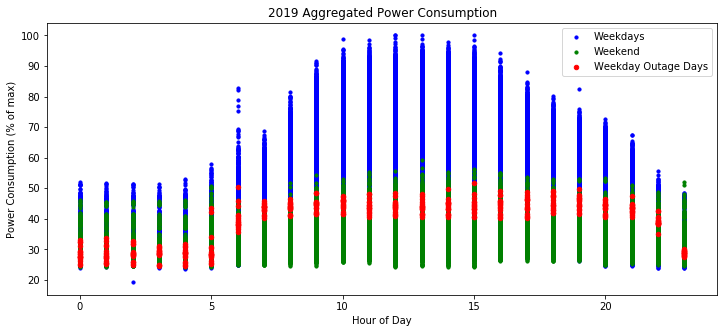

In [8]:
fig,ax = plot_cons(scrambled_1)
ax.set_title('2019 Aggregated Power Consumption')

## Forecasting and Prediction Modeling

Generalized functions were created to prepare data from any building for modelling. This way additional buildings can be prepared for modelling with only about 3 minutes of data checking and cleaning.

Apart from data cleaning, these functions add interaction terms suing time-of-year classification and  weather predictors. Observations were catagorized as is_summer (summer break), is_winter (winter break), or neither (regular semester). These catagories were multiplied with weather data such that there were three sets of weather columns afterwards: one for summer, one for winter, and one for the regular semester. All predictor columns were then normalized.

Furthermore, hour-of-day was one hot encoded into 24 columns and historical power consumption from one week prior to prediction time as a predictor.

In [9]:
def prepare_df(building_data):
    '''
    Adds predictors to df with only energy data for building
    '''
    #Add hour column
    building_data['Hour'] = building_data.Date.dt.hour
    #Merge electricity and weather data
    building_data = pd.merge(building_data,weather,left_on='Date',right_on='Date_Time',how='left')
    building_data.drop(columns='Date_Time',inplace=True)
    building_data.dropna(inplace=True)
    building_data.reset_index(inplace=True,drop=True) 
    #Add other predictors
    building_data_wknd = building_data[building_data.Date.dt.weekday>4]
    building_data = drop_weekend(building_data)
    building_data = add_seasons(building_data,weather_X)
    building_data = add_past_kW(building_data)
    building_data_X = building_data.columns[3:].values #predictor names
    building_data[building_data_X] = normalize(building_data[building_data_X]) #normalize columns that are continuous
    building_data = is_hour_columns(building_data)
    building_data_X = building_data.columns[3:].values #predictor names update
    return building_data,building_data_X

def drop_weekend(df):
    '''
    Drops weekend observations.
    '''
    df = df[df.Date.dt.weekday<5]
    return df

def is_hour_columns(df):
    '''
    Adds one column to df per hour of day. Boolean values indicating if observation is in this hour.
    '''
    for h in range(24):
        df[str(h)+'oclock'] = (df.Date.dt.hour == h)
    return df

def add_seasons(df,weather_X):
    '''
    Adds season columns interacted w/ weather measurements
    ''' 
    day = df.Date.dt.dayofyear
    for mea in weather_X:
        df['is_winter']=0
        df.is_winter[(day<20) | (day>355)] = 1
        df['winter '+mea] = 0
        df['winter '+mea][(day<20) | (day>355)] = df[mea][(day<20) | (day>355)]
        df[mea][(day<20) | (day>355)] = 0 #remove obs during winter
        
        df['is_summer']=0
        df.is_summer[(day>140) & (day<228)] = 1
        df['summer '+mea] = 0
        df['summer '+mea][(day>140) & (day<228)] = df[mea][(day>140) & (day<228)]
        df[mea][(day>140) & (day<228)] = 0  
    return df

def add_past_kW(df):
    '''
    Adds power consumption from 1 week prior to observation as predictors. Power consumption would be useful
    but were removed because they disrupt predictions during power outage days.
    '''
    #last_15 = df[['Date','kW']]
    #last_15.Date = last_15.Date+pd.Timedelta(minutes=15)
    #last_15.rename(columns={'kW':'last_15_kW'},inplace=True)
    #df = pd.merge(df,last_15,on=['Date'])

    #last_hour = df[['Date','kW']]
    #last_hour.Date = last_hour.Date+pd.Timedelta(hours=1)
    #last_hour.rename(columns={'kW':'last_hour_kW'},inplace=True)
    #df = pd.merge(df,last_hour,on=['Date'])

    last_week = df[['Date','kW']]
    last_week.Date = last_week.Date+pd.Timedelta(weeks=1)
    last_week.rename(columns={'kW':'last_week_kW'},inplace=True)
    df = pd.merge(df,last_week,on=['Date'])
    return df

#Functions for Modelling
def test_on_rand(df,df_X):
    '''
    Random train-test split with power outage days removed.
    '''
    df_1 = df[df.Date.dt.date!=pd.to_datetime('2019/10/03')]
    df_1 = df[~(df.Date.between(off1[0], off1[1])+df.Date.between(off2[0], off2[1]))]
    X,X_test,y,y_test = train_test_split(df_1[df_X],df_1['kW'],random_state = 1, test_size = 0.25)
    return X,X_test,y,y_test

def test_on_oct(df,df_X):
    '''
    Test set is October 2019 so power outage days are not trained on.
    '''
    split_date = pd.to_datetime('2019-10-01')
    X = df.loc[df.Date<split_date,df_X]
    y = df.loc[df.Date<split_date,'kW']
    X_test = df.loc[df.Date>split_date,df_X]
    y_test = df.loc[df.Date>split_date,'kW']
    return X,X_test,y,y_test

def retrieve_name(x, Vars=vars()):
    '''
    Returns variable name as string
    '''
    for k in Vars:
        if type(x) == type(Vars[k]):
            if x is Vars[k]:
                return k
    return None

def fit_model(Model,k,alphas,Tol=0.1):
    '''
    Returns MAE's for input alphas and optimal alpha. For Ridge, Lasso & ElasticNet.
    '''
    maes = np.zeros((k,len(alphas)))
    kf = KFold(n_splits=k,shuffle=True,random_state=1)

    fold = 0
    for train_index,val_index in kf.split(X):
        X_train = X.reset_index(drop=True).loc[train_index,:]
        y_train = y.reset_index(drop=True)[train_index]#.loc[train_index,:]
        X_val = X.reset_index(drop=True).loc[val_index,:]
        y_val = y.reset_index(drop=True)[val_index]#.loc[val_index,:]

        for i in range(len(alphas)): #train model for each alpha
            model = Model(alpha=alphas[i],tol=Tol)
            model.fit(X_train,y_train)
            yhat_val = model.predict(X_val)
            maes[fold,i] = mean_absolute_error(y_val,yhat_val)
        fold += 1
        avg_maes = np.mean(maes,axis=0)
        
    return avg_maes,alphas[np.argmin(avg_maes)] #average val maes for each alpha

def test_model(Model,best_alpha,Tol):
    '''
    Returns test MAE for Ridge, Lasso & ElasticNet.
    '''
    model = Model(alpha=best_alpha,tol=Tol)
    model.fit(X,y)
    yhat_test = model.predict(X_test)
    model_test_mae = mean_absolute_error(y_test,yhat_test)
    return model_test_mae #test mae for optimum alpha

def plot_model(X_plot,Model,best_alpha,Tol):
    '''
    Returns yhat_plot values given X_plot so that model output can be plotted.
    '''
    model = Model(alpha=best_alpha,tol=Tol)
    model.fit(X,y)
    yhat_plot = model.predict(X_plot)
    return yhat_plot #for visualizing predictions

def fit_knr(kfolds,ks):
    '''
    Returns MAE's for input k's and optimal k value. For KNeighborsRegressor.
    '''
    maes = np.zeros((kfolds,len(ks)))
    kf = KFold(n_splits=kfolds,shuffle=True,random_state=1)

    fold = 0
    for train_index,val_index in kf.split(X):
        X_train = X.reset_index(drop=True).loc[train_index,:]
        y_train = y.reset_index(drop=True)[train_index]#.loc[train_index,:]
        X_val = X.reset_index(drop=True).loc[val_index,:]
        y_val = y.reset_index(drop=True)[val_index]#.loc[val_index,:]

        for i in range(len(ks)): #train model for each k value
            model = KNeighborsRegressor(n_neighbors=ks[i])
            model.fit(X_train,y_train)
            yhat_val = model.predict(X_val)
            maes[fold,i] = mean_absolute_error(y_val,yhat_val)
        fold += 1
        avg_maes = np.mean(maes,axis=0)
        
    return avg_maes,ks[np.argmin(avg_maes)] #average val maes for each k value

#Final preparation of data before modelling.
scrambled_1,scrambled_1_X = prepare_df(scrambled_1)

Following is a choose-your-own-adventure cell where the desired building is selected to be modelled. As mentioned, this demonstration uses scrambled data from an anonymous UCB building.

Furthermore, the train-test-split method also chosen here. The first randomly splits the with 25% of data saved for testing, the second reserves October 2019 for the test set. The random split is good for evaluating model accuracy for predicting throughout the year. The October split is useful for creating visualizations of test predictions. 

Blackout days are excluded entirely on the random split.

In [10]:
#SETUP MODEL HERE
#1)Choose Dataframe
building = 'scrambled_1'
df = scrambled_1
df_X = scrambled_1_X #List of predictor names

#2) Choose how to split data:
X,X_test,y,y_test = test_on_rand(df,df_X)

#OR:
#X,X_test,y,y_test = test_on_oct(df,df_X)

The simple linear model performs moderately well with a MAE of 1049kW (true y varies from 15,000kW to 30,000kW). Observing the coefficients shows that all predictors are somewhat used.

In [11]:
#Linear Model
lm = LinearRegression()
fit = lm.fit(X,y)
yhat_train = lm.predict(X)
yhat_test = lm.predict(X_test)
lm_test_mae = mean_absolute_error(y_test,yhat_test)
lm_r2 = r2_score(y_test,yhat_test)
print('Train MAE=',mean_absolute_error(y,yhat_train))
print('Test MAE=',mean_absolute_error(y_test,yhat_test))
print('R2 Score =',lm_r2)

#Observe Coefficients
array = np.concatenate((df_X.reshape(1,-1),lm.coef_.reshape(1,-1)),axis=0)
(pd.DataFrame(array))

Train MAE= 4.984946378076158
Test MAE= 4.9942468739274
R2 Score = 0.8245786952762413


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
0,pressure_set_1,air_temp_set_1,relative_humidity_set_1,wind_speed_set_1,wind_gust_set_1,precip_accum_fifteen_minute_set_1,solar_radiation_set_1,dew_point_temperature_set_1d,sea_level_pressure_set_1d,is_winter,winter pressure_set_1,is_summer,summer pressure_set_1,winter air_temp_set_1,summer air_temp_set_1,winter relative_humidity_set_1,summer relative_humidity_set_1,winter wind_speed_set_1,summer wind_speed_set_1,winter wind_gust_set_1,summer wind_gust_set_1,winter precip_accum_fifteen_minute_set_1,summer precip_accum_fifteen_minute_set_1,winter solar_radiation_set_1,summer solar_radiation_set_1,winter dew_point_temperature_set_1d,summer dew_point_temperature_set_1d,winter sea_level_pressure_set_1d,summer sea_level_pressure_set_1d,last_week_kW,0oclock,1oclock,2oclock,3oclock,4oclock,5oclock,6oclock,7oclock,8oclock,9oclock,10oclock,11oclock,12oclock,13oclock,14oclock,15oclock,16oclock,17oclock,18oclock,19oclock,20oclock,21oclock,22oclock,23oclock
1,81174.2,65825.8,2686.38,-22098,23902.4,-114970,178.242,-8119.75,93043.1,9.68886e+06,24118.4,2.10315e+07,103951,720065,-170121,20216.5,3580.19,13994.3,-47302.3,-40349.9,-29714.5,59344.5,8539.52,-5632.78,-948.431,11757.1,7724.01,148094,70807.2,37785.4,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12,-1.72492e+12


Ridge, lasso, and elastic nets were then applied. Cross validation yielded essentially 0 alpha values all models; the models are effectively identical the linear regression model. This means that most predictors are useful and the linear model does not substantially overfit the training data.

In [12]:
# Regularizaion Methods
k = 3
ridge_alphas = np.linspace(10**-20,10*-0,num=20)#np.linspace(10**-100,10*-50,num=20)
ridge_val_maes,ridge_alpha0 = fit_model(Ridge,k,ridge_alphas,Tol=1)

lasso_alphas = np.linspace(10**-50,10**-8,num=20)
lasso_val_maes,lasso_alpha0 = fit_model(Lasso,k,lasso_alphas,Tol=1)
elasticnet_alphas = np.linspace(10**-50,10**-8,num=20)
elasticnet_val_maes,elasticnet_alpha0 = fit_model(ElasticNet,k,elasticnet_alphas,Tol=1)

print('Ridge val MAE for tested alphas:',ridge_val_maes)
print('Lasso val MAE for tested alphas:',lasso_val_maes)
print('ElasticNet val MAE for tested alphas:',elasticnet_val_maes)

Ridge val MAE for tested alphas: [4.99066752 4.99066752 4.99066753 4.99066751 4.99066755 4.99066753
 4.99066751 4.99066748 4.99066753 4.99066752 4.99066749 4.99066751
 4.99066752 4.99066753 4.99066749 4.99066751 4.99066752 4.99066753
 4.99066751 4.99039141]
Lasso val MAE for tested alphas: [5.54355832 5.54350439 5.54345056 5.54339507 5.54333882 5.54330655
 5.54332484 5.5433406  5.54332479 5.54330901 5.54329326 5.54327751
 5.54326178 5.54324605 5.54323044 5.54321493 5.54319941 5.54318408
 5.54316946 5.543155  ]
ElasticNet val MAE for tested alphas: [5.54355832 5.8799329  5.8783026  5.87542073 5.87346737 5.87247827
 5.8722837  5.87271456 5.87356843 5.874742   5.87614769 5.8777388
 5.8795487  5.88153021 5.88369156 5.88598338 5.8883594  5.89082987
 5.89338302 5.89599046]


In [13]:
#Regularization Methods Test Score
ridge_test_mae = test_model(Ridge,ridge_alpha0,Tol=0.01)
lasso_test_mae = test_model(Ridge,lasso_alpha0,Tol=0.1)
elasticnet_test_mae = test_model(Ridge,elasticnet_alpha0,Tol=0.1)
ridge_r2 = r2_score(y_test,yhat_test)
lasso_r2 = r2_score(y_test,yhat_test)
elasticnet_r2 = r2_score(y_test,yhat_test)

print('Ridge Test MAE: ', ridge_test_mae)
print('Lasso Test MAE: ', lasso_test_mae)
print('ElasticNet Test MAE: ', elasticnet_test_mae)
print('Ridge R2 Score:', ridge_r2)
print('Lasso R2 Score:', lasso_r2)
print('Elastic Net R2 Score:', elasticnet_r2)

Ridge Test MAE:  4.994284518222463
Lasso Test MAE:  4.991680370869619
ElasticNet Test MAE:  4.994284518222463
Ridge R2 Score: 0.8245786952762413
Lasso R2 Score: 0.8245786952762413
Elastic Net R2 Score: 0.8245786952762413


Next a single tree tuned with RandomizedSearchCV on maximum leaf nodes, maximum features, and maximum depth was used. The tree performed much worse than linear models. (n_iter and cv values were reduced for the demonstration to reduce running time.)

In [14]:
#Single Tree [Slow]
tree = DecisionTreeRegressor()
param_dist = {'max_leaf_nodes': randint(3, 100),
              'max_features': randint(2, 25),
              'max_depth': randint(1, 50)}
rnd_tree = RandomizedSearchCV(tree, param_distributions=param_dist,cv=3, n_iter=10, random_state = 1)
rnd_tree.fit(X,y)
yhat = rnd_tree.predict(X)
yhat_test = rnd_tree.predict(X_test)
tree_train_mae = mean_absolute_error(yhat,y)
tree_test_mae = mean_absolute_error(yhat_test,y_test)
tree_r2 = r2_score(yhat_test,y_test)
print('Tree Test MAE: ', tree_test_mae)
print('Tree R2 Score:', tree_r2)

Tree Test MAE:  4.78359260004776
Tree R2 Score: 0.8044071287020897


Bagging, random forests, and gradient boosting were also applied, RandomizedSearchCV was attempted however crashed the Jupyter Notebook Kernel. Untuned bagging and random forests still outperformed linear models with random forests performing best. This is probably because bagging and random forests are less likely to overfit the data compared to single trees yet are more flexible than linear models with non-linear relationships.

In [15]:
#Bagging, Random Forests, and Gradient Boosting
bag = BaggingRegressor(random_state = 1, n_estimators = 100, max_samples = 1.0, max_features = 1.0)
bag.fit(X, y)
yhat = bag.predict(X)
yhat_test = bag.predict(X_test)
bag_train_mae = mean_absolute_error(yhat_train,y)
bag_test_mae = mean_absolute_error(yhat_test,y_test)
bag_r2 = r2_score(yhat_test,y_test)
print('Bag Test MAE: ', bag_test_mae)
print('Bag R2 Score:', bag_r2)

rf = RandomForestRegressor()
rf.fit(X, y)
yhat = rf.predict(X)
yhat_test = rf.predict(X_test)
rf_train_mae = mean_absolute_error(yhat,y)
rf_test_mae = mean_absolute_error(yhat_test,y_test)
rf_r2 = r2_score(yhat_test,y_test)
print('RF Test MAE: ', rf_test_mae)
print('RF R2 Score:', rf_r2)

gb = GradientBoostingRegressor()
gb.fit(X, y)
yhat = gb.predict(X)
yhat_test = gb.predict(X_test)
gb_train_mae = mean_absolute_error(yhat,y)
gb_test_mae = mean_absolute_error(yhat_test,y_test)
gb_r2 = r2_score(yhat_test,y_test)
print('GB Test MAE: ', gb_test_mae)
print('GB R2 Score:', gb_r2)

Bag Test MAE:  3.500446393278068
Bag R2 Score: 0.8844251645404944
RF Test MAE:  3.4916073415112896
RF R2 Score: 0.8846940971379894
GB Test MAE:  4.92064450100418
GB R2 Score: 0.7894761698355854


Finally, K Nearest Regressor was used with the optimal K value of 2 found through cross validation. K nearest regressor performs worse than the linear models.

In [16]:
#K Neighbors Regression
#Cross Validate knr for best k value
ks = np.arange(1,3,1)
knr_val_maes,k0 = fit_knr(3,ks)
#Test knr using best k value k0
knr = KNeighborsRegressor(n_neighbors=k0)
knr.fit(X,y)
yhat = knr.predict(X)
yhat_test = knr.predict(X_test)
knr_train_mae = mean_absolute_error(y,yhat)
knr_test_mae = mean_absolute_error(y_test,yhat_test)
knr_r2 = r2_score(y_test,yhat_test)
print('Validation MAEs for tested k values: ',knr_val_maes)
print('Best k Value: ',k0)
print('KNR Test MAE: ',knr_test_mae)
print('KNR R2 Score: ',knr_r2)

Validation MAEs for tested k values:  [4.87655817 4.64437671]
Best k Value:  2
KNR Test MAE:  4.311825460114413
KNR R2 Score:  0.8322486158463229


In [17]:
#List of all models used
#Model_types = ('Linear Model','Ridge','Lasso','Elastic Net','Single Tree','Bagging','Optimized Bagging',
#               'Random Forest','Optimized RF','Gradient Boosting', 'K Nearest Regressor')
Model_types = ('Linear Model','Ridge','Lasso','Elastic Net','Single Tree','Bagging',
               'Random Forest','Gradient Boosting', 'K Nearest Regressor')


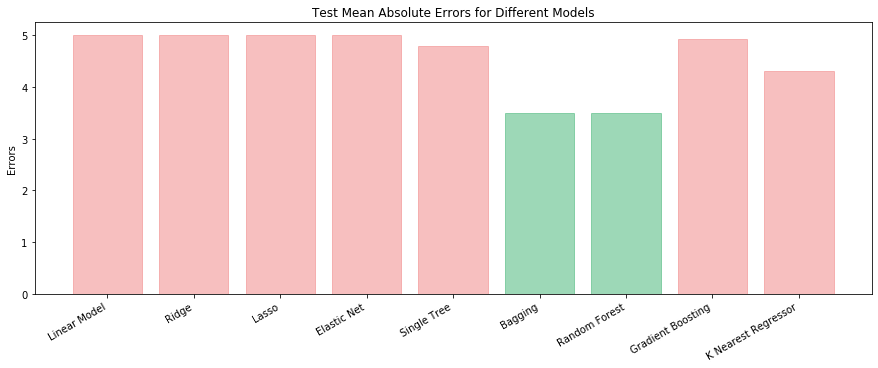

In [18]:
#Compares MAE of each model
plt.figure(1, figsize=(15, 5))
y_pos = np.arange(len(Model_types))
errors= [lm_test_mae,ridge_test_mae,lasso_test_mae,elasticnet_test_mae,tree_test_mae,bag_test_mae,
         rf_test_mae,gb_test_mae,knr_test_mae]
bargraph=plt.bar(y_pos, errors, align='center', alpha=0.5)
for i in range(len(Model_types)):
    bargraph[i].set_color('lightcoral')
bargraph[5].set_color('mediumseagreen')
bargraph[6].set_color('mediumseagreen')
plt.xticks(y_pos, Model_types,rotation=30, ha='right')
plt.ylabel('Errors')
plt.title('Test Mean Absolute Errors for Different Models')
plt.show()

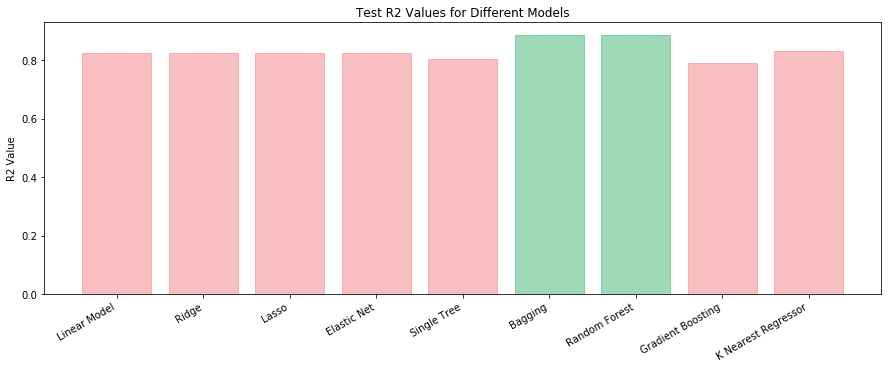

In [19]:
#Compares R2 value of each model
plt.figure(1, figsize=(15, 5))
#Model_types = ('Linear Model','Ridge','Lasso','Elastic Net','Single Tree','Bagging','Optimized Bagging',
#               'Random Forest','Optimized RF','Gradient Boosting', 'K Nearest Regressor')
y_pos = np.arange(len(Model_types))
errors= [lm_r2,ridge_r2,lasso_r2,elasticnet_r2,tree_r2,bag_r2,rf_r2,
        gb_r2,knr_r2]
bargraph=plt.bar(y_pos, errors, align='center', alpha=0.5)
for i in range(len(Model_types)):
    bargraph[i].set_color('lightcoral')
bargraph[5].set_color('mediumseagreen')
bargraph[6].set_color('mediumseagreen')
plt.xticks(y_pos, Model_types,rotation=30, ha='right')
plt.ylabel('R2 Value')
plt.title('Test R2 Values for Different Models')
plt.show()

The following function plots predicted power consumption against actual power consumpton for a given day. Plots for 10/03/2019 and 10/10/2019 (power outage day) are made.

In [20]:
#Visualization Functions
def visualize_all(df,df_X,date):
    '''
    Plots All Methods
    '''
    if pd.to_datetime(date).weekday()>4:
        print("Model doesn't include weekends!")
    df_subset = df[df.Date.dt.date==pd.to_datetime(date)]
    x_axis = df_subset.Date.dt.hour+df_subset.Date.dt.minute/60

    lm_subset = lm.predict(df_subset[df_X])
    ridge_subset = plot_model(df_subset[df_X],Ridge,ridge_alpha0,Tol=0.01)
    lasso_subset = plot_model(df_subset[df_X],Lasso,lasso_alpha0,Tol=0.01)
    elasticnet_subset = plot_model(df_subset[df_X],ElasticNet,elasticnet_alpha0,Tol=0.01)
    tree_subset = rnd_tree.predict(df_subset[df_X])
    bag_subset = bag.predict(df_subset[df_X])
    rf_subset = rf.predict(df_subset[df_X])
    gb_subset = gb.predict(df_subset[df_X])
    knr_subset = knr.predict(df_subset[df_X])

    plt.figure(figsize=(16,6))
    plt.ylim=(0,120)
    plt.scatter(x_axis,df_subset.kW,c='royalblue')
    plt.plot(x_axis,lm_subset,c='orange')
    plt.plot(x_axis,ridge_subset,c='sienna')
    plt.plot(x_axis,lasso_subset,c='salmon')
    plt.plot(x_axis,elasticnet_subset,c='mediumseagreen')
    plt.plot(x_axis,tree_subset,c='navy')
    plt.plot(x_axis,bag_subset,c='teal')
    plt.plot(x_axis,rf_subset,c='darkorchid')
    plt.plot(x_axis,gb_subset,c='grey')
    plt.plot(x_axis,knr_subset,c='firebrick')
    plt.legend(Model_types)
    plt.legend(['Linear Model','Ridge','Lasso','Elastic Net',
                'Tree','Bagging','Random Forest','Gradient Boosting','K Neighbors','Data Points'])
    plt.title('Predicted and Actual Power Consumption on '+str(date))
    plt.xlabel('Hour of Day')
    plt.ylabel('Power consumption (% of max)')
    return

def visualize_rf(df,df_X,date):
    '''
    Plots All Methods
    '''
    if pd.to_datetime(date).weekday()>4:
        print("Model doesn't include weekends!")
    df_subset = df[df.Date.dt.date==pd.to_datetime(date)]
    x_axis = df_subset.Date.dt.hour+df_subset.Date.dt.minute/60
    
    rf_subset = rf.predict(df_subset[df_X])

    plt.figure(figsize=(16,6))
    plt.ylim=(0,120)
    plt.scatter(x_axis,df_subset.kW,c='royalblue')
    plt.plot(x_axis,rf_subset,c='darkorchid')
    plt.xlabel('Hour of Day')
    plt.ylabel('Power consumption (% of max)')
    plt.title('Random Forest Prediction and Actual Power Consumption on '+str(date))
    return

def visualize_rnd_rf(df,df_X,date):
    '''
    Plots All Methods
    '''
    if pd.to_datetime(date).weekday()>4:
        print("Model doesn't include weekends!")
    df_subset = df[df.Date.dt.date==pd.to_datetime(date)]
    x_axis = df_subset.Date.dt.hour+df_subset.Date.dt.minute/60
    
    rf_subset = rnd_rf.predict(df_subset[df_X])

    plt.figure(figsize=(16,6))
    plt.ylim=(0,120)
    plt.scatter(x_axis,df_subset.kW,c='royalblue')
    plt.plot(x_axis,rf_subset,c='darkorchid')
    plt.xlabel('Hour of Day')
    plt.ylabel('Power consumption (% of max)')
    plt.title('Random Forest Prediction and Actual Power Consumption on '+str(date))
    return

Here we plot predicted versus actual power consumption on 10/03/2019. Data from this date was manually removed from the training data for this demonstration.

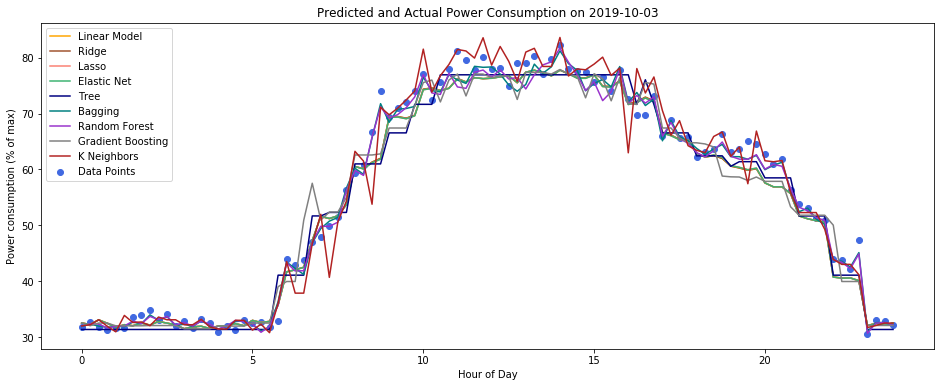

In [21]:
date = '2019-10-03' #CHOOSE DATE HERE

visualize_all(df,df_X,date)
plt.legend(['Linear Model','Ridge','Lasso','Elastic Net','Tree','Bagging','Random Forest',
            'Gradient Boosting','K Neighbors','Data Points'],loc='upper left')
plt.savefig('data/figures/'+building+'_'+str(date)+'.png')

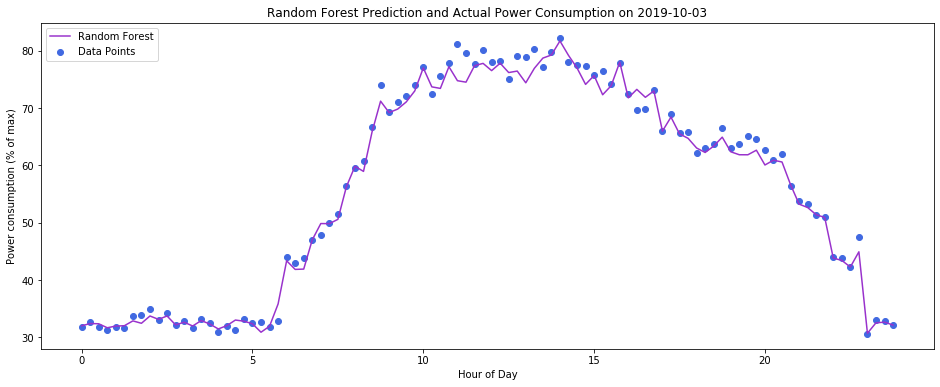

In [22]:
date = '2019-10-03' #CHOOSE DATE HERE

visualize_rf(df,df_X,date)
plt.legend(['Random Forest','Data Points'],loc='upper left')
plt.savefig('data/figures/'+building+'_'+str(date)+'.png')

Here we plot predicted versus actual power consumption on 10/10/2019. Data from this date was automatically removed from the training data since it was a power outage day. The predictions here represent energy consumption if the campus had run normally that day.

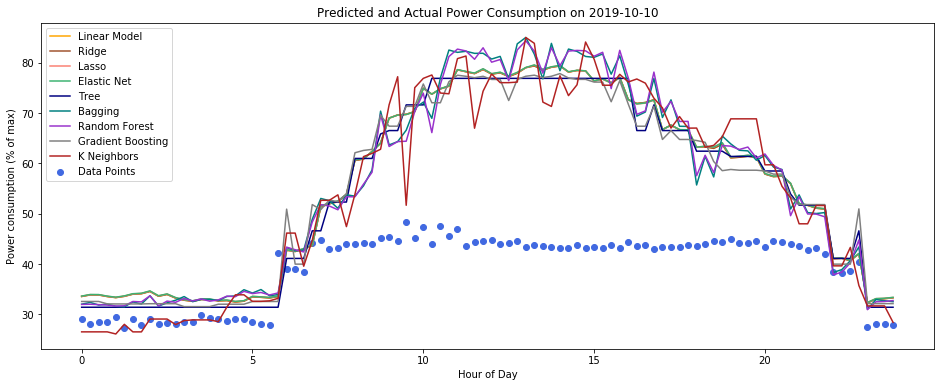

In [23]:
date = '2019-10-10' #CHOOSE DATE HERE

#visualize_linear(df,df_X,date)
#visualize_trees(df,df_X,date)
visualize_all(df,df_X,date)

plt.legend(['Linear Model','Ridge','Lasso','Elastic Net','Tree','Bagging','Random Forest',
            'Gradient Boosting','K Neighbors','Data Points'],loc='upper left')
plt.savefig('data/figures/'+building+'_'+str(date)+'.png')

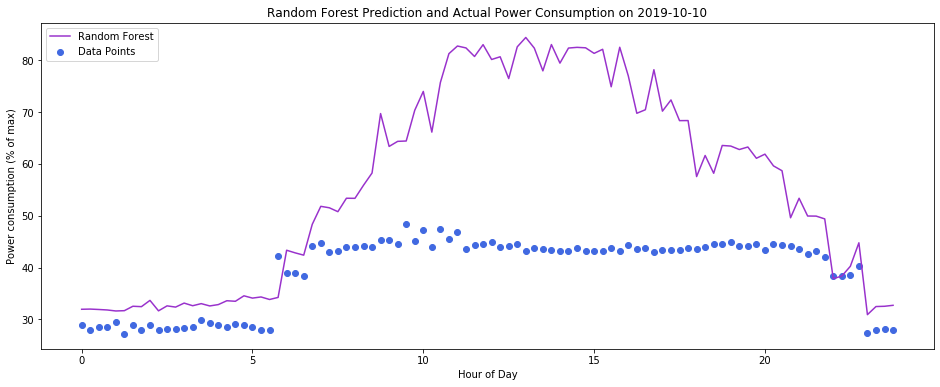

In [24]:
date = '2019-10-10' #CHOOSE DATE HERE

visualize_rf(df,df_X,date)

plt.legend(['Random Forest','Data Points'],loc='upper left')
plt.savefig('data/figures/'+building+'_'+str(date)+'.png')

Model accuracy statistics are saved to be compared with models for other buildlings.

In [25]:
#Make report for model
report = {'Item':[building+'- Test MAE',building+'- R2 Value',building+'- Alpha/K value'],
          'Linear Model':[lm_test_mae,lm_r2,np.nan],'Ridge':[ridge_test_mae,ridge_r2,ridge_alpha0],
          'Lasso':[lasso_test_mae,lasso_r2,lasso_alpha0],
          'Elastic Net':[elasticnet_test_mae,elasticnet_r2,elasticnet_alpha0],
          'Tree':[tree_test_mae,tree_r2,np.nan],'Bagging':[bag_test_mae,bag_r2,np.nan],
          'Random Forest':[rf_test_mae,rf_r2,np.nan],
          'Gradient Boosting':[gb_test_mae,gb_r2,np.nan],'K Nearest Regressor':[knr_test_mae,knr_r2,k0]}
report = pd.DataFrame(report)
report.to_csv('data/reports/'+building+'.csv')
report.head()

,Item,Linear Model,Ridge,Lasso,Elastic Net,Tree,Bagging,Random Forest,Gradient Boosting,K Nearest Regressor
0,scrambled_1- Test MAE,4.994247,4.994285,4.991680e+00,4.994285e+00,4.783593,3.500446,3.491607,4.920645,4.311825
1,scrambled_1- R2 Value,0.824579,0.824579,8.245787e-01,8.245787e-01,0.804407,0.884425,0.884694,0.789476,0.832249
2,scrambled_1- Alpha/K value,NaN,0.000000,1.000000e-08,1.000000e-50,NaN,NaN,NaN,NaN,2.000000


## Interpretation and Conclusions 

The results from these models excitingly show that building power consumption can be predicted with high accuracy given weather and historical power consumption data.Some buildings performed better then others with further analysis needed to see a correlation between model accuracy and building type. Given more computation power, prediction accuracy could be increased further through tuned random forests. 

These models could inform how many UCB buildings can be run off the campus cogeneration plant during PG&E power outages given weather conditions. To do this, the 3-minute cleaning process would be performed on all buildings being considered for operation. The predicted campus load would then be the sum of the models' outputs plus the baseline load of other buildings. This may allow certain facilities such as libraries to remain open during future outages. This modelling technique could also be applied to other buildings outside of UCB which have electrical heating and cooling systems. Natural gas consumption would probably also be predictable in this manner. UCB energy consumption is notably different from the duck-curve of city-level energy consumption, instead, its trend matches hourly solar PV production quite well. If more solar were installed on campus, a predictive model for solar power production could be used in conjunction with this model to keep more buildings open during power outages.

Though this is a predictive model, it is appropriate to acknowledge the direct impact weather has on building electricity consumption. Furthermore, additional features such as thermostat settings could be inlcuded. With this, the models could predict building energy consumption at different energy-conservation settings rather than at a single 'building-on' setting.

Currently the model uses high time-resolution weather data for predictions. However, assuming that weather is stable across the following 15 or 30 minutes, the model can accurately forecast power consumption in the following minutes/hour. However, decision makers probably also want to have predictions a day or more in advance. Therefore, a version of this model should be built using forcasted weather data.

In the power-outage scenario, over-predicting power consumption is less consequential then under-predicting it. The current methodology does not favour over-prediction over under-prediction, this would be another next-step improvement. Finally, as mentioned earlier, the model currently does not predict for weekends. However, this is important since the campus occasionally consumes above 24.5kW on weekends during peak consumption. Therefore, weekend predictions should either be incorporated into the model through more interaction terms, or a second model should be created for weekend predictions. 